# Compare Performance of DeepLabV3 Training Runs for Main Experiment

TODO: The results currently saved to this notebook are for a simplistic cursory experiment that only fine-tuned the last layer of DeepLabV3 on a small subset of the Cityscapes data using constant learning rate and standard cross-entropy loss. All experiments are to be redone with improve training schemes that achieve SOTA or near-SOTA performance.

TODO: Update this so that mIoU with background excluded is the primary metric.

In [1]:
# Standard
import os
import pickle
from pprint import pprint
from typing import Any, Dict, List, Optional, Set, Tuple

# Numerics
import numpy as np

# Visualization
import matplotlib.pyplot as plt
from tqdm import tqdm

# Image Processing
import cv2
import imageio.v3 as imageio

# Machine Learning
import pandas as pd
import albumentations as albm  # Faster than `torchvision.transforms`.
import pytorch_lightning as pl

In [2]:
# Project-Specific
from core import (
    SemanticClassId,
    SemanticClassMapping,
    SparseLabelSimulatingDataset,
)
from core.visualization import (
    scale_plot_size,
)
from data.cityscapes import (
    class_mapping,
    preprocesses_from,
    subcityscapes_dataset,
    cityscapes_dataset,
    TargetClassNumPixelsCache,
)
from experiments import (
    #model_name_from_run_dirname,
    get_latest_run_dirname,
    TrainingRun,
    #compute_semantic_class_weights,
    abbreviate_runs_path,
    evaluate_training_run,
    plot_model_outputs_side_by_side,
    models_performance_comparison_df,
    models_performance_comparison_texttable_str,
)

In [3]:
scale_plot_size(factor=1.8)
%config InlineBackend.close_figures = False

In [4]:
pl.seed_everything(13)

Seed set to 13


13

In [5]:
REPO_ROOT: str = os.environ.get("REPO_ROOT")
assert REPO_ROOT is not None, \
    "REPO_ROOT not found! Did you run `setenv.sh` before serving the notebook?"
CITYSCAPES_DATA_ROOT: str = os.path.join(REPO_ROOT, "data/cityscapes")

---

## Load Data

In [6]:
preprocesses: Dict[str, albm.Compose] = preprocesses_from(
    input_height=320,
    input_width=640,
    mean_for_input_normalization=(0.485, 0.456, 0.406),
    std_for_input_normalization=(0.229, 0.224, 0.225),
    #do_shift_scale_rotate=...,  # Not relevant here since we're only using
    #ignore_index=...,           # the "infer" preprocessing.
)
preprocess: albm.Compose = preprocesses["infer"]

In [7]:
num_pixels_cache_filename: str = os.path.join(
    REPO_ROOT,
    "src/data/cityscapes/",
    "target_class_num_pixels_cache.pkl",
)
with open(num_pixels_cache_filename, "rb") as fin:
    target_class_num_pixels_cache: TargetClassNumPixelsCache = pickle.load(fin)

In [8]:
#dataset_eval_name: str = "subcityscapes_val"
#split: str = "val"

dataset_eval_name: str = "subcityscapes_test"
split: str = "test"

dataset_eval: SparseLabelSimulatingDataset = subcityscapes_dataset(
    split=split,  # "train", "val", "trainval", or "test".
    preprocess=preprocess,
    len_scale_factor=1.0,
    label_density=1.0,
    ignore_index=255,
    shuffle=False,
    target_class_num_pixels=target_class_num_pixels_cache.get(
        dataset_name="subcityscapes_test",
        len_scale_factor=1.0,
        label_density=1.0,
    ),
)

---

## Load Runs

In [9]:
# Gather run directories.
layers_to_train: str = "final_layer"
#layers_to_train: str = "all_layers"
scenario_dirnames: List[str] = [
    os.path.join(REPO_ROOT, "runs/deeplabv3", f"{layers_to_train}_000"),
    os.path.join(REPO_ROOT, "runs/deeplabv3", f"{layers_to_train}_001"),
    os.path.join(REPO_ROOT, "runs/deeplabv3", f"{layers_to_train}_002"),
    os.path.join(REPO_ROOT, "runs/deeplabv3", f"{layers_to_train}_003"),
]
run_dirnames: List[str] = [
    get_latest_run_dirname(scenario_dirname)
    for scenario_dirname in scenario_dirnames
]
print("Run directories identified:")
for run_dirname in run_dirnames:
    print(abbreviate_runs_path(run_dirname))

Run directories identified:
.../runs/deeplabv3/final_layer_000/2023-12-29T00_38_36Z
.../runs/deeplabv3/final_layer_001/2023-12-29T06_16_17Z
.../runs/deeplabv3/final_layer_002/2023-12-29T16_16_36Z
.../runs/deeplabv3/final_layer_003/2023-12-29T20_28_47Z


In [10]:
# Construct list of runs.
runs: List[TrainingRun] = \
    [ TrainingRun(run_dirname) for run_dirname in run_dirnames ]
run_names: List[str] = ["Run 0", "Run 1", "Run 2", "Run 3"]
run_summary_metrics: List[Dict[str, float]] = \
    [ run.load_summary_metrics(dataset_eval_name) for run in runs ]

In [11]:
# Creat run list sorted by descending mIoU.
miou_ix_pairs: List[Tuple[float, int]] = []
for ix, run in enumerate(runs):
    miou_ix_pairs.append((run_summary_metrics[ix]["miou"], ix))
miou_ix_pairs.sort(reverse=True)
runs_sorted: List[TrainingRun] = \
    [ runs[ix] for _, ix in miou_ix_pairs ]
run_names_sorted: List[str] = \
    [ run_names[ix] for _, ix in miou_ix_pairs ]
run_summary_metrics_sorted: List[Dict[str, float]] = \
    [ run_summary_metrics[ix] for _, ix in miou_ix_pairs ]

---

## Generate Model Output Examples

<Figure size 1800x1800 with 0 Axes>

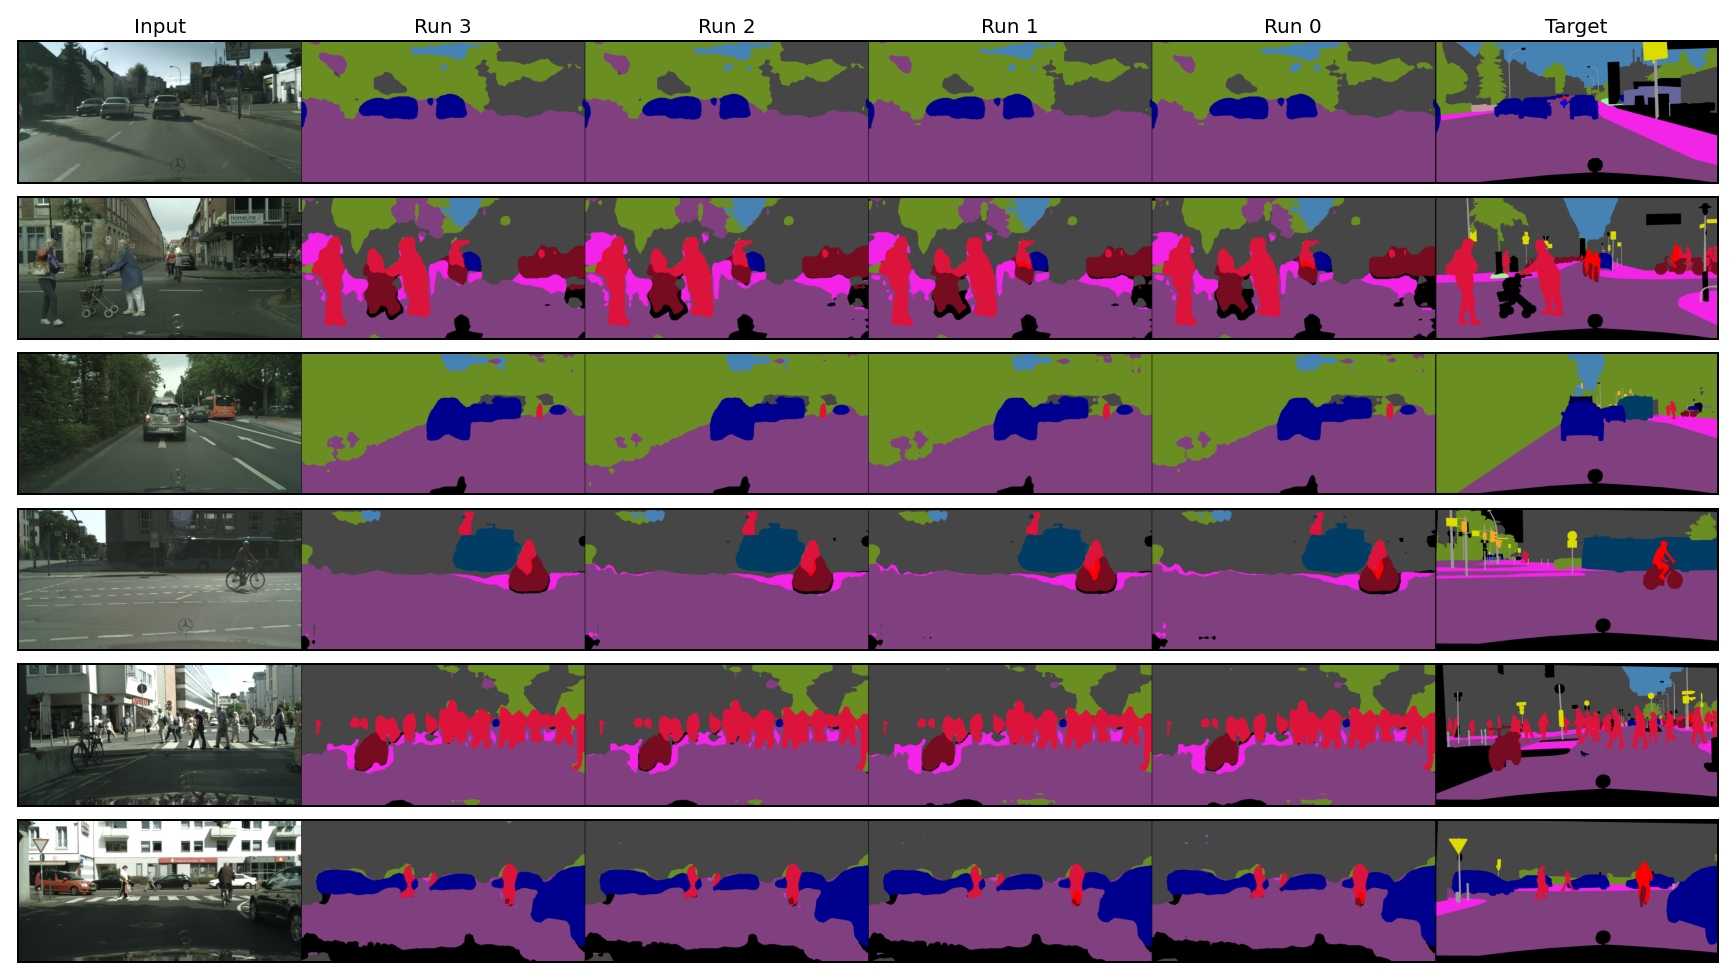

In [12]:
# Plot model outputs side-by-side together with the input image and target
# segmentation map.
if True:
    # Select indices of data examples to use. The first few were hand-picked for
    # subcityscapes_test aka cityscapes_val.
    #
    # Possible improvement here: Use `dataset.target_class_num_pixels_cache`
    # to automatically select examples for comparing models.
    
    ixs: List[int] = [15, 170, 181, 304, 316, 367]
    num_examples: int = len(dataset_eval)
    ixs_other_set: Set[int] = set(range(num_examples))
    ixs_other_set.difference_update(ixs)
    ixs_other: List[int] = list(ixs_other_set)
    np.random.shuffle(ixs_other)
    ixs.extend(ixs_other)
    
    plot_model_outputs_side_by_side(
        runs=list(reversed(runs_sorted)),
        dataset=dataset_eval,
        example_ixs=ixs[:6],
        include_targets=True,
        run_names=list(reversed(run_names_sorted)),
        #run_names=None,
    )
    # plt.savefig(
    #     os.path.join(
    #         dirname,
    #         "side-by-sides.png",
    #     ),
    #     bbox_inches="tight",
    #     pad_inches=0.05,
    #     dpi=500,
    # )
    # plt.close()

---

## Generate Metrics Tables

In [13]:
# Set the hyperparameters to include in tables.
hparams_names: List[str] = [
    "len_dataset_train_scale_factor",
    "len_dataset_val_scale_factor",
    "label_density",
]

In [14]:
# Set the summary metrics to include in tables.
summary_metric_names: List[str] = [
    "pixel_accuracy",
    "mean_pixel_accuracy",
    "miou_background_excluded",
    "miou",
]

In [18]:
comparison_df: pd.DataFrame = models_performance_comparison_df(
    runs=runs_sorted,
    dataset_eval_name=dataset_eval_name,
    hparam_names=hparams_names,
    summary_metric_names=summary_metric_names,
    run_names=run_names_sorted,
    #run_names=None,
)
comparison_df

,run_name,len_dataset_train_scale_factor,len_dataset_val_scale_factor,label_density,pixel_accuracy,mean_pixel_accuracy,miou_background_excluded,miou
0,Run 0,1.0,1.0,1.0,0.670461,0.329778,0.249013,0.266279
1,Run 1,1.0,1.0,0.5,0.668755,0.324128,0.242964,0.260295
2,Run 2,0.5,0.5,1.0,0.664544,0.314938,0.238078,0.255303
3,Run 3,0.5,0.5,0.5,0.662954,0.306216,0.229417,0.246340


In [16]:
if True:
    comparison_texttable: str = models_performance_comparison_texttable_str(
        runs=runs_sorted,
        dataset_eval_name=dataset_eval_name,
        hparam_names=hparams_names,
        summary_metric_names=summary_metric_names,
        run_names=run_names_sorted,
        #run_names=None,
    )
    print(comparison_texttable)

+----------+---------+---------+---------+---------+---------+---------+-------+
| run_name | len_dat | len_dat | label_d | pixel_a | mean_pi | miou_ba | miou  |
|          | aset_tr | aset_va | ensity  | ccuracy | xel_acc | ckgroun |       |
|          | ain_sca | l_scale |         |         |  uracy  | d_exclu |       |
|          | le_fact | _factor |         |         |         |   ded   |       |
|          |   or    |         |         |         |         |         |       |
+==========+=========+=========+=========+=========+=========+=========+=======+
|    Run 0 |  1.000  |  1.000  |  1.000  |  0.670  |  0.330  |  0.249  | 0.266 |
+----------+---------+---------+---------+---------+---------+---------+-------+
|    Run 1 |  1.000  |  1.000  |  0.500  |  0.669  |  0.324  |  0.243  | 0.260 |
+----------+---------+---------+---------+---------+---------+---------+-------+
|    Run 2 |  0.500  |  0.500  |  1.000  |  0.665  |  0.315  |  0.238  | 0.255 |
+----------+---------+------

---

## Plot Segmentation Performance vs Labeling Effort

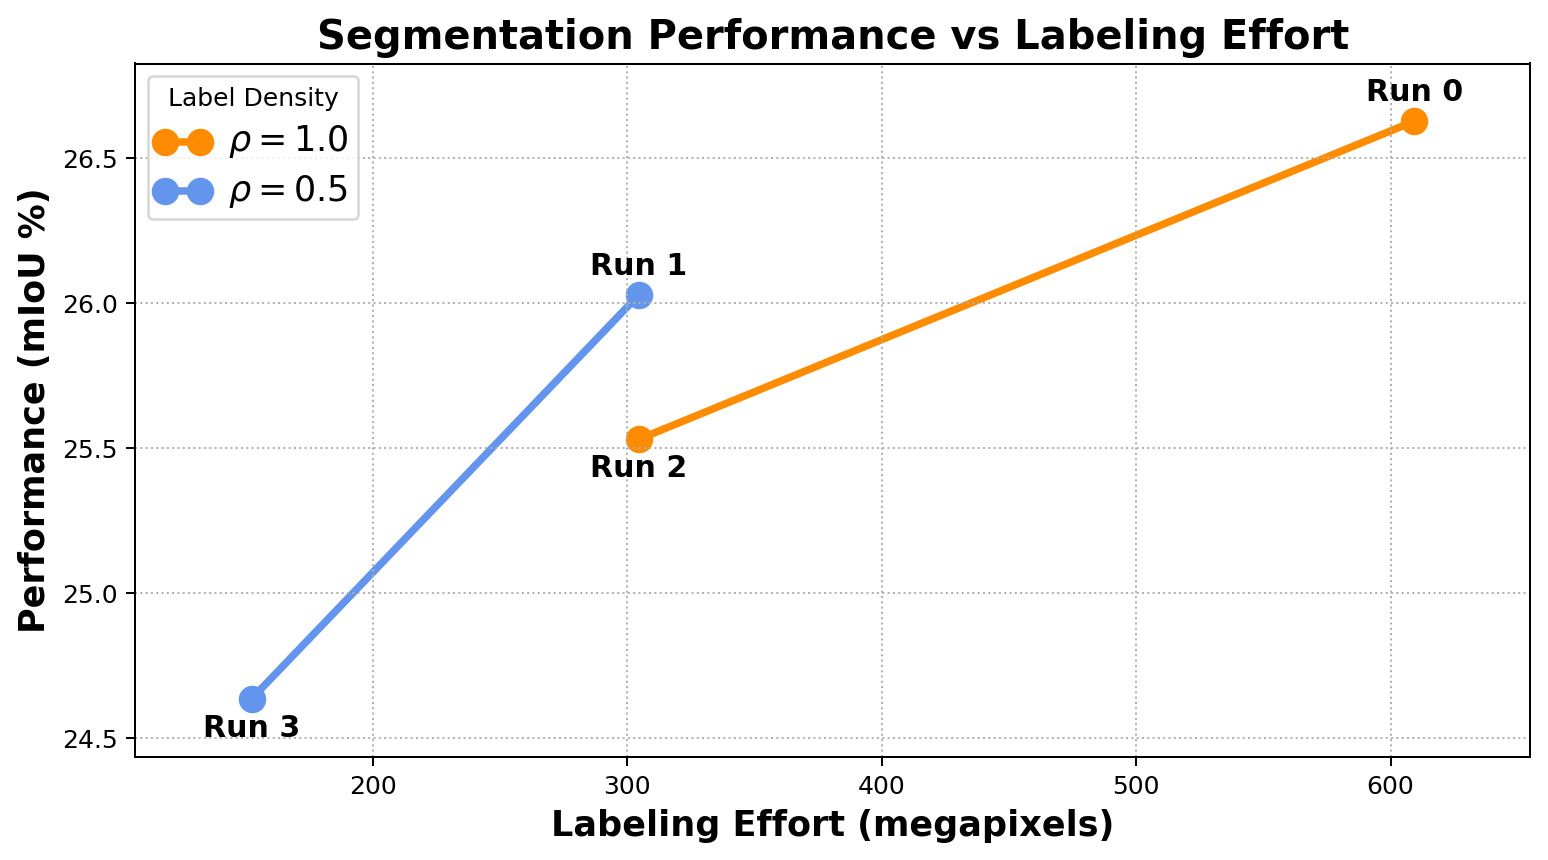

In [17]:
num_megapixels_subcityscapes_trainval: float = 609.28
# = float(609_280_000/1e6) = float(320*640*2975/1e6)

xs_1pt0: List[float] = [
    num_megapixels_subcityscapes_trainval,
    0.5*num_megapixels_subcityscapes_trainval,
]
ys_1pt0: List[float] = [
    100.0*run_summary_metrics[0]["miou"],
    100.0*run_summary_metrics[2]["miou"],
]

xs_0pt5: List[float] = [
    0.5*num_megapixels_subcityscapes_trainval,
    0.25*num_megapixels_subcityscapes_trainval,
]
ys_0pt5: List[float] = [
    100.0*run_summary_metrics[1]["miou"],
    100.0*run_summary_metrics[3]["miou"],
]

plt.clf()
plt.figure(figsize=(10.0, 5.0))

dy_text: float = 0.05  # Extra clearance between text and point.
plt.text(
    x=num_megapixels_subcityscapes_trainval,
    y=100.0*run_summary_metrics[0]["miou"] + dy_text,
    s="Run 0",
    fontsize=12,
    fontweight="bold",
    horizontalalignment="center",  # left, center, right
    verticalalignment="bottom",  # bottom, baseline, center, center_baseline, top
)
plt.text(
    x=0.5*num_megapixels_subcityscapes_trainval,
    y=100.0*run_summary_metrics[1]["miou"] + dy_text,
    s="Run 1",
    fontsize=12,
    fontweight="bold",
    horizontalalignment="center",  # left, center, right
    verticalalignment="bottom",  # bottom, baseline, center, center_baseline, top
)
plt.text(
    x=0.5*num_megapixels_subcityscapes_trainval,
    y=100.0*run_summary_metrics[2]["miou"] - dy_text,
    s="Run 2",
    fontsize=12,
    fontweight="bold",
    horizontalalignment="center",  # left, center, right
    verticalalignment="top",  # bottom, baseline, center, center_baseline, top
)
plt.text(
    x=0.25*num_megapixels_subcityscapes_trainval,
    y=100.0*run_summary_metrics[3]["miou"] - dy_text,
    s="Run 3",
    fontsize=12,
    fontweight="bold",
    horizontalalignment="center",  # left, center, right
    verticalalignment="top",  # bottom, baseline, center, center_baseline, top
)

# Higher zorder => foreground, lower zorder => background.
plt.plot(
    xs_1pt0, ys_1pt0, "o-",
    label=r"$\rho = 1.0$",
    color="darkorange",
    linewidth=3.0,
    markersize=10.0,
    zorder=0.0,
)
plt.plot(
    xs_0pt5, ys_0pt5, "o-",
    label=r"$\rho = 0.5$",
    color="cornflowerblue",
    linewidth=3.0,
    markersize=10.0,
    zorder=0.0,
)

plt.title(
    "Segmentation Performance vs Labeling Effort",
    fontsize=16,
    fontweight="bold",
)
plt.ylabel("Performance (mIoU %)", fontsize=14, fontweight="bold")
plt.xlabel("Labeling Effort (megapixels)", fontsize=14, fontweight="bold")

legend = plt.legend(title="Label Density", numpoints=2)
plt.setp(legend.get_texts(), fontsize="14", fontweight="bold")

ax = plt.gca()
ax.margins(0.1)
#ax.set_yscale("log")
#plt.xlim((lbnd, ubnd))
#plt.ylim((lbnd, ubnd))
plt.grid(True, linestyle=":")

# plt.savefig(
#     os.path.join(
#         dirname,
#         "performence_vs_labeling_effort.png",
#     ),
#     bbox_inches="tight",
#     pad_inches=0.05,
#     dpi=500,
# )
# plt.close()